In [1]:
using MAT

# datasets from http://www.rctn.org/bruno/sparsenet/
mat_images = matopen("../_static/datasets/IMAGES.mat")
imgs = read(mat_images, "IMAGES")

close(mat_images)

In [2]:
using Base: @kwdef
using Parameters: @unpack # or using UnPack
using LinearAlgebra, Random, Statistics, PyPlot, ProgressMeter

In [3]:
@kwdef struct RBParameter{FT}
    α::FT = 1.0
    αh::FT = 0.05
    var::FT = 1.0
    vartd::FT = 10
    inv_var::FT = 1/var       
    inv_vartd::FT = 1/vartd
    k1::FT = 0.3 # k_1: update rate
    λ::FT = 0.02 # regularization parameter
end

@kwdef mutable struct RaoBallard1999Model{FT}
    param::RBParameter = RBParameter{FT}()
    num_units_lv0::UInt16 = 256 # number of units of level0
    num_units_lv1::UInt16 = 32
    num_units_lv2::UInt16 = 128
    num_lv1::UInt16 = 3
    k2::FT = 0.2 # k_2: learning rate
    r::Array{FT} = zeros(num_lv1, num_units_lv1) # activity of neurons
    rh::Array{FT} = zeros(num_units_lv2) # activity of neurons
    U::Array{FT} = randn(num_units_lv0, num_units_lv1) .* sqrt(2.0 / (num_units_lv0+num_units_lv1))
    Uh::Array{FT} = randn(num_lv1*num_units_lv1, num_units_lv2) .* sqrt(2.0 / (num_lv1*num_units_lv1+num_units_lv2))
end

In [4]:
function update!(variable::RaoBallard1999Model, param::RBParameter, inputs::Array, training::Bool)
    @unpack num_units_lv0, num_units_lv1, num_units_lv2, num_lv1, k2, r, rh, U, Uh = variable
    @unpack α, αh, var, vartd, inv_var, inv_vartd, k1, λ = param

    r_reshaped = r[:] # (96)

    fx = r * U' # (3, 256)
    fxh = Uh * rh # (96, )

    # Calculate errors
    error = inputs - fx # (3, 256)
    errorh = r_reshaped - fxh # (96, ) 
    errorh_reshaped = reshape(errorh, (num_lv1, num_units_lv1)) # (3, 32)

    g_r = α * r ./ (1.0 .+ r .^ 2) # (3, 32)
    g_rh = αh * rh ./ (1.0 .+ rh .^ 2) # (64, )

    # Update r and rh
    dr = k1 * (inv_var * error * U - inv_vartd * errorh_reshaped - g_r)
    drh = k1 * (inv_vartd * Uh' * errorh - g_rh)
    
    r[:, :] += dr
    rh[:] += drh
    
    if training 
        U[:, :] += k2 * (inv_var * error' * r - num_lv1 * λ * U)
        Uh[:, :] += k2 * (inv_vartd * errorh * rh' - λ * Uh)
    end

    return error, errorh, dr, drh
end

update! (generic function with 1 method)

In [5]:
# Gaussian mask for inputs
function GaussianMask(sizex=16, sizey=16, sigma=5)
    x = 0:sizex-1
    y = 0:sizey-1
    X = [i for i in x, j in 1:length(y)]
    Y = [j for i in 1:length(x), j in y]
    
    x0 = (sizex-1) / 2
    y0 = (sizey-1) / 2
    mask = exp.(-((X .- x0) .^2 + (Y .- y0) .^2) / (2.0*(sigma^2)))
    return mask ./ sum(mask)
end

GaussianMask (generic function with 4 methods)

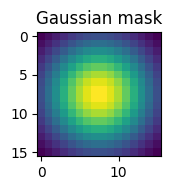

In [6]:
gau = GaussianMask()
figure(figsize=(2,2))
title("Gaussian mask")
imshow(gau)
tight_layout()

In [7]:
function calculate_total_error(error, errorh, variable::RaoBallard1999Model, param::RBParameter)
    @unpack num_units_lv0, num_units_lv1, num_units_lv2, num_lv1, k2, r, rh, U, Uh = variable
    @unpack α, αh, var, vartd, inv_var, inv_vartd, k1, λ = param
    recon_error = inv_var * sum(error.^2) + inv_vartd * sum(errorh.^2)
    sparsity_r = α * sum(r.^2) + αh * sum(rh.^2)
    sparsity_U = λ * (sum(U.^2) + sum(Uh.^2))
    return recon_error + sparsity_r + sparsity_U
end

calculate_total_error (generic function with 1 method)

In [8]:
function run_simulation(imgs, num_iter, nt_max, eps)
    # Define model
    model = RaoBallard1999Model{Float32}()
    
    # Simulation constants
    H, W, num_images = size(imgs)
    input_scale = 40 # scale factor of inputs
    gmask = GaussianMask() # Gaussian mask
    errorarr = zeros(num_iter) # Vector to save errors    
    
    # Run simulation
    @showprogress "Computing..." for iter in 1:num_iter
        # Get images randomly
        idx = rand(1:num_images)
        img = imgs[:, :, idx]

        # Get the coordinates of the upper left corner of clopping image randomly.
        beginx = rand(1:W-27)
        beginy = rand(1:H-17)
        img_clopped = img[beginy:beginy+15, beginx:beginx+25]

        # Clop three patches
        inputs = hcat([(gmask .* img_clopped[:, 1+i*5:i*5+16])[:] for i = 0:2]...)'
        inputs = (inputs .- mean(inputs)) .* input_scale

        # Reset states
        model.r = inputs * model.U 
        model.rh = model.Uh' * model.r[:]

        # Input an image patch until latent variables are converged 
        for i in 1:nt_max
            # Update r and rh without update weights 
            error, errorh, dr, drh = update!(model, model.param, inputs, false)

            # Compute norm of r and rh
            dr_norm = sqrt(sum(dr.^2))
            drh_norm = sqrt(sum(drh.^2))

            # Check convergence of r and rh, then update weights
            if dr_norm < eps && drh_norm < eps
                error, errorh, dr, drh = update!(model, model.param, inputs, true)
                errorarr[iter] = calculate_total_error(error, errorh, model, model.param) # Append errors
                break
            end

            # If failure to convergence, break and print error
            if i >= nt_max-2
                println("Error at patch:", iter)
                println(dr_norm, drh_norm)
                break
            end
        end


        # Decay learning rate         
        if iter % 40 == 39
            model.k2 /= 1.015
        end

        # Print moving average error
        if iter % 1000 == 0
            moving_average_error = mean(errorarr[iter-999:iter])
            println("[", iter, "/", num_iter, "] Moving average error:", moving_average_error)
        end
    end
    return model, errorarr
end

run_simulation (generic function with 1 method)

In [9]:
# Simulation constants
num_iter = 5000 # number of iterations
nt_max = 1000 # Maximum number of simulation time
eps = 1e-3 # small value which determines convergence

model, errorarr = run_simulation(imgs, num_iter, nt_max, eps);

Computing...  1%|█                                      |  ETA: 0:06:03

Computing...  1%|█                                      |  ETA: 0:05:02

Computing...  2%|█                                      |  ETA: 0:04:21

Computing...  2%|█                                      |  ETA: 0:03:44

Computing...  2%|█                                      |  ETA: 0:03:12

Computing...  3%|██                                     |  ETA: 0:02:44

Computing...  3%|██                                     |  ETA: 0:02:18

Computing...  4%|██                                     |  ETA: 0:01:58

Computing...  5%|██                                     |  ETA: 0:01:42

Computing...  6%|███                                    |  ETA: 0:01:28

Computing...  6%|███                                    |  ETA: 0:01:18

Computing...  7%|███                                    |  ETA: 0:01:09

Computing...  8%|████                                   |  ETA: 0:01:02

Computing...  9%|████                                   |  ETA: 0:00:58

Computing... 10%|████                                   |  ETA: 0:00:52

Computing... 11%|█████                                  |  ETA: 0:00:49

Computing... 12%|█████                                  |  ETA: 0:00:46

Computing... 13%|█████                                  |  ETA: 0:00:43

Computing... 14%|██████                                 |  ETA: 0:00:40

Computing... 14%|██████                                 |  ETA: 0:00:38

Computing... 15%|██████                                 |  ETA: 0:00:36

Computing... 16%|███████                                |  ETA: 0:00:34

Computing... 17%|███████                                |  ETA: 0:00:32

Computing... 18%|████████                               |  ETA: 0:00:31

Computing... 19%|████████                               |  ETA: 0:00:29

Computing... 20%|████████                               |  ETA: 0:00:28

[1000/5000] Moving average error:2.019791928593583


Computing... 21%|█████████                              |  ETA: 0:00:27

Computing... 22%|█████████                              |  ETA: 0:00:26

Computing... 23%|█████████                              |  ETA: 0:00:25

Computing... 24%|██████████                             |  ETA: 0:00:24

Computing... 25%|██████████                             |  ETA: 0:00:23

Computing... 26%|███████████                            |  ETA: 0:00:22

Computing... 27%|███████████                            |  ETA: 0:00:22

Computing... 28%|███████████                            |  ETA: 0:00:21

Computing... 29%|████████████                           |  ETA: 0:00:20

Computing... 30%|████████████                           |  ETA: 0:00:19

Computing... 31%|█████████████                          |  ETA: 0:00:19

Computing... 32%|█████████████                          |  ETA: 0:00:18

Computing... 33%|█████████████                          |  ETA: 0:00:18

Computing... 34%|██████████████                         |  ETA: 0:00:17

Computing... 35%|██████████████                         |  ETA: 0:00:17

Computing... 36%|██████████████                         |  ETA: 0:00:16

Computing... 37%|███████████████                        |  ETA: 0:00:16

Computing... 37%|███████████████                        |  ETA: 0:00:15

Computing... 38%|███████████████                        |  ETA: 0:00:15

Computing... 39%|████████████████                       |  ETA: 0:00:15

[2000/

Computing... 40%|████████████████                       |  ETA: 0:00:14

5000] Moving average error:1.6316126984722923


Computing... 41%|█████████████████                      |  ETA: 0:00:14

Computing... 42%|█████████████████                      |  ETA: 0:00:14

Computing... 43%|█████████████████                      |  ETA: 0:00:13

Computing... 44%|██████████████████                     |  ETA: 0:00:13

Computing... 45%|██████████████████                     |  ETA: 0:00:12

Computing... 46%|██████████████████                     |  ETA: 0:00:12

Computing... 47%|███████████████████                    |  ETA: 0:00:12

Computing... 48%|███████████████████                    |  ETA: 0:00:12

Computing... 49%|████████████████████                   |  ETA: 0:00:11

Computing... 50%|████████████████████                   |  ETA: 0:00:11

Computing... 51%|████████████████████                   |  ETA: 0:00:11

Computing... 52%|█████████████████████                  |  ETA: 0:00:10

Computing... 53%|█████████████████████                  |  ETA: 0:00:10

Computing... 54%|█████████████████████                  |  ETA: 0:00:10

Computing... 55%|██████████████████████                 |  ETA: 0:00:09

Computing... 55%|██████████████████████                 |  ETA: 0:00:09

Computing... 56%|██████████████████████                 |  ETA: 0:00:09

Computing... 57%|███████████████████████                |  ETA: 0:00:09

Computing... 58%|███████████████████████                |  ETA: 0:00:09

Computing... 59%|████████████████████████               |  ETA: 0:00:08

Computing... 60%|████████████████████████               |  ETA: 0:00:08

[3000/5000] Moving average error:1.7431830577370755


Computing... 61%|████████████████████████               |  ETA: 0:00:08

Computing... 62%|█████████████████████████              |  ETA: 0:00:08

Computing... 63%|█████████████████████████              |  ETA: 0:00:07

Computing... 64%|█████████████████████████              |  ETA: 0:00:07

Computing... 65%|██████████████████████████             |  ETA: 0:00:07

Computing... 66%|██████████████████████████             |  ETA: 0:00:07

Computing... 67%|███████████████████████████            |  ETA: 0:00:06

Computing... 68%|███████████████████████████            |  ETA: 0:00:06

Computing... 69%|███████████████████████████            |  ETA: 0:00:06

Computing... 71%|████████████████████████████           |  ETA: 0:00:06

Computing... 72%|████████████████████████████           |  ETA: 0:00:05

Computing... 73%|█████████████████████████████          |  ETA: 0:00:05

Computing... 74%|█████████████████████████████          |  ETA: 0:00:05

Computing... 75%|██████████████████████████████         |  ETA: 0:00:05

Computing... 76%|██████████████████████████████         |  ETA: 0:00:05

Computing... 77%|██████████████████████████████         |  ETA: 0:00:04

Computing... 78%|███████████████████████████████        |  ETA: 0:00:04

Computing... 79%|███████████████████████████████        |  ETA: 0:00:04

Computing... 79%|███████████████████████████████        |  ETA: 0:00:04

[4000/5000] Moving average error:1.7724392603457204


Computing... 80%|████████████████████████████████       |  ETA: 0:00:04

Computing... 82%|████████████████████████████████       |  ETA: 0:00:03

Computing... 83%|█████████████████████████████████      |  ETA: 0:00:03

Computing... 85%|█████████████████████████████████      |  ETA: 0:00:03

Computing... 85%|██████████████████████████████████     |  ETA: 0:00:03

Computing... 86%|██████████████████████████████████     |  ETA: 0:00:02

Computing... 87%|██████████████████████████████████     |  ETA: 0:00:02

Computing... 88%|███████████████████████████████████    |  ETA: 0:00:02

Computing... 89%|███████████████████████████████████    |  ETA: 0:00:02

Computing... 90%|████████████████████████████████████   |  ETA: 0:00:02

Computing... 91%|████████████████████████████████████   |  ETA: 0:00:02

Computing... 92%|████████████████████████████████████   |  ETA: 0:00:01

Computing... 93%|█████████████████████████████████████  |  ETA: 0:00:01

Computing... 94%|█████████████████████████████████████  |  ETA: 0:00:01

Computing... 95%|██████████████████████████████████████ |  ETA: 0:00:01

Computing... 96%|██████████████████████████████████████ |  ETA: 0:00:01

Computing... 97%|██████████████████████████████████████ |  ETA: 0:00:01

Computing... 98%|███████████████████████████████████████|  ETA: 0:00:00

Computing... 99%|███████████████████████████████████████|  ETA: 0:00:00

Computing...100%|███████████████████████████████████████|  ETA: 0:00:00

Computing...100%|███████████████████████████████████████| Time: 0:00:17


[5000/5000] Moving average error:1.6751733813991379


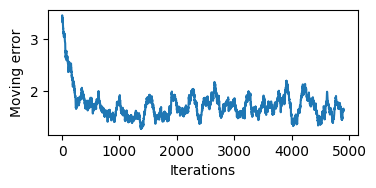

In [10]:
function moving_average(x, n=100)
    ret = cumsum(x)
    ret[n:end] = ret[n:end] - ret[1:end-n+1]
    return ret[n - 1:end] / n
end

# Plot error
moving_average_error = moving_average(errorarr)
figure(figsize=(4, 2))
ylabel("Moving error")
xlabel("Iterations")
plot(1:size(moving_average_error)[1], moving_average_error)
tight_layout()

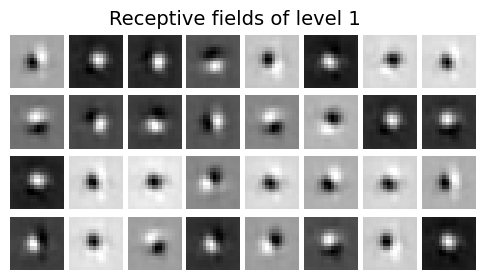

In [11]:
# Plot Receptive fields
figure(figsize=(6, 3))
subplots_adjust(hspace=0.1, wspace=0.1)
for i in 1:32
    subplot(4, 8, i)
    imshow(reshape(model.U[:, i], (16, 16)), cmap="gray")
    axis("off")
end
suptitle("Receptive fields of level 1", fontsize=14)
subplots_adjust(top=0.9)

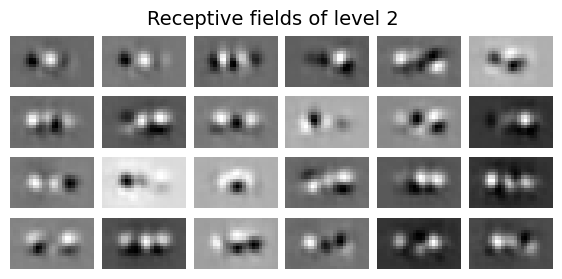

In [12]:
# Plot Receptive fields of level 2
zero_padding = zeros(80, 32)
U0 = [model.U; zero_padding; zero_padding]
U1 = [zero_padding; model.U; zero_padding]
U2 = [zero_padding; zero_padding; model.U]
U_ = [U0 U1 U2]
Uh_ = U_ * model.Uh 

figure(figsize=(7, 3))
subplots_adjust(hspace=0.1, wspace=0.1)
for i in 1:24
    subplot(4, 6, i)
    imshow(reshape(Uh_[:, i], (16, 26)), cmap="gray")
    axis("off")
end

suptitle("Receptive fields of level 2", fontsize=14)
subplots_adjust(top=0.9)